In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression,LogisticRegression


In [2]:
import os,sys
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [3]:
dirPathJuice = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-12-12_3_'
dirPathOrder = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_'


In [4]:
def regreessBehavior(choiceB,qAs,qBs,seqAB=None):
    idx=(qAs!=0)&(qBs!=0)
    if seqAB is not None:
        X = np.vstack((np.log(qBs[idx]/qAs[idx]),seqAB[idx])).T
    else:
        X = np.log(qBs[idx]/qAs[idx]).reshape(-1,1)
    y = choiceB[idx]
    model = LogisticRegression()
    model.fit(X,y)
    return model
    # return model.intercept_[0], model.coef_[0]
def getIndPoint(dirPath):
    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')
    choiceB = np.array([0 if choiceAB[i]=='A' else 1 for i in range(len(trial_params))])
    model = regreessBehavior(choiceB,qAs,qBs)
    a0,(a1,) = model.intercept_[0], model.coef_[0]
    indPoint = np.exp(-a0/a1)
    return indPoint

def importAndPreprocess(dirPath,activityFileName):
    import os
    import sys

    
    with np.load(os.path.join(dirPath,activityFileName),allow_pickle=True) as f:
        x = f['x']
        trial_params = f['trial_params']
        model_output = f['model_output']
        model_state = f['model_state']
        mask = f.get('mask', None)
    
    if mask is None:
        temp = np.mean(model_output[:,300:,:],1)
    else: 
        temp = np.mean(mask * model_output,1)
    choiceLR = temp[:,1]>temp[:,0]
    choiceLR = choiceLR*2-1 # pos right high, neg left high
    
    choiceFrame = [trial_params[i]['choiceFrame'] for i in range(len(trial_params))]
    
    
    locAB = [(1 if trial_params[i]['locAB']=='AB' or trial_params[i]['locAB']=='12' else -1) for i in range(len(trial_params))]
    loc12 = locAB
    seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]
    
    choiceAB = np.array([(choiceLR[i] * locAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i] * seqAB[i]) for i in range(len(trial_params)) ])  # pos B neg A
    choice12 = np.array([(choiceAB[i] * seqAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i]) for i in range(len(trial_params)) ])  # pos 2 neg 1
    choiceAB = np.array(['B' if choiceAB[i]>0 else 'A' for i in range(len(trial_params))])
    choice12 = np.array(['2' if choice12[i]>0 else '1' for i in range(len(trial_params))])
    
    qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
    qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
    seqAB = np.array([trial_params[i]['seqAB']for i in range(len(trial_params))])

    return x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB
def importTuningVariables(dirPath):
    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTestCross.npz')
    indPoint=getIndPoint(dirPath)
    valueA = qAs*indPoint
    qBs = qBs*1.0
    valueB = qBs*1.0
    choiceAB = np.array([-1 if choiceAB[i]=='A' else 1 for i in range(len(trial_params))])
    choice12 = np.array([-1 if choice12[i]=='1' else 1 for i in range(len(trial_params))])
    seqAB = np.array([(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))])
    value1 = np.array([qAs[i]*indPoint if seqAB[i]>0 else qBs[i] for i in range(len(trial_params))])
    value2 = np.array([qAs[i]*indPoint if seqAB[i]<0 else qBs[i] for i in range(len(trial_params))])
    valueA_AB = qAs.copy()*indPoint
    valueA_BA = qAs.copy()*indPoint
    valueB_AB = qBs.copy()
    valueB_BA = qBs.copy()
    valueA_AB[seqAB<0] = 0
    valueA_BA[seqAB>0] = 0
    valueB_AB[seqAB<0] = 0
    valueB_BA[seqAB>0] = 0
    valueChosen = np.array([qAs[i]*indPoint if choiceAB[i]<0 else qBs[i] for i in range(len(trial_params))])
    valueChosenA = valueChosen.copy()
    valueChosenA[choiceAB>0] = 0
    valueChosenB = valueChosen.copy()
    valueChosenB[choiceAB<0] = 0
    valueDiffAB = valueA-valueB
    valueDiff12 = value1-value2

    return seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12

def importTuningActivity(dirPath):
    import os
    with np.load(os.path.join(dirPath,'activitityTestCross.npz'),allow_pickle=True) as f:
        model_state = f['model_state']
    y2 = model_state[:,80:100,:].mean(axis=1)
    y4 = model_state[:,180:200,:].mean(axis=1)
    return y2,y4

def getRegCoeff(dirPath):
    y2,y4 = importTuningActivity(dirPath)
    seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12 = importTuningVariables(dirPath)

    b11,b12 = LinearRegression().fit(np.vstack((value1,value2)).T,y2).coef_.T
    b21,b22 = LinearRegression().fit(np.vstack((value1,value2)).T,y4).coef_.T


    b11AB,b12AB = LinearRegression().fit(np.vstack((value1[seqAB==1],value2[seqAB==1])).T,y2[seqAB==1]).coef_.T
    b21AB,b22AB = LinearRegression().fit(np.vstack((value1[seqAB==1],value2[seqAB==1])).T,y4[seqAB==1]).coef_.T
    b11BA,b12BA = LinearRegression().fit(np.vstack((value1[seqAB==-1],value2[seqAB==-1])).T,y2[seqAB==-1]).coef_.T
    b21BA,b22BA = LinearRegression().fit(np.vstack((value1[seqAB==-1],value2[seqAB==-1])).T,y4[seqAB==-1]).coef_.T

    b11p = ((b11AB+b11BA)/2)
    b12p = ((b12AB+b12BA)/2)
    b21p = ((b21AB+b21BA)/2)
    b22p = ((b22AB+b22BA)/2)

    return (b11,b12,b21,b22),(b11AB,b12AB,b21AB,b22AB),(b11BA,b12BA,b21BA,b22BA),(b11p,b12p,b21p,b22p)

def getCorrOfReg(dirPath):
    (b11,b12,b21,b22),(b11AB,b12AB,b21AB,b22AB),(b11BA,b12BA,b21BA,b22BA),(b11p,b12p,b21p,b22p) = getRegCoeff(dirPath)
    c11_21  = np.corrcoef(b11 ,b21 )[0,1]
    c11_22  = np.corrcoef(b11 ,b22 )[0,1]
    c21_22  = np.corrcoef(b21 ,b22 )[0,1]
    c11_21p = np.corrcoef(b11p,b21p)[0,1]
    c11_22p = np.corrcoef(b11p,b22p)[0,1]
    c21_22p = np.corrcoef(b21p,b22p)[0,1]    

    return  c11_21 , c11_22 , c21_22 , c11_21p, c11_22p, c21_22p 

In [5]:
import os
dirName = 'juiceTaskDefault'
juiceCorr = []
dirPathsJuice = []
root = "/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/"+dirName
for name in os.listdir(root):
    dirPath = os.path.join(root,name)
    if os.path.isdir(dirPath):
        c11_21 , c11_22 , c21_22 , c11_21p, c11_22p, c21_22p = getCorrOfReg(dirPath)
        juiceCorr.append([c11_21 , c11_22 , c21_22 , c11_21p, c11_22p, c21_22p])
        dirPathsJuice.append(dirPath)
juiceCorr = np.array(juiceCorr)

juiceCorr

array([[ 0.43460644,  0.6563057 ,  0.03441146,  0.51273356,  0.75127654,
         0.04978371],
       [ 0.81641629, -0.67528909, -0.80995272,  0.81352969, -0.15793423,
        -0.55733352],
       [ 0.635331  ,  0.1677497 , -0.48893072,  0.72557736,  0.26183209,
        -0.41426122],
       ...,
       [ 0.81869282,  0.65447547,  0.53598352,  0.85826793,  0.75299332,
         0.49916068],
       [ 0.67135904,  0.08467663, -0.26821963,  0.76333328,  0.55963049,
         0.10009366],
       [ 0.7132211 ,  0.03462953, -0.34397533,  0.77054467,  0.21816553,
        -0.35444114]])

In [6]:
dirName = 'orderTaskDefault'
orderCorr = []
dirPathsOrder = []
root = "/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/"+dirName
for name in os.listdir(root):
    dirPath = os.path.join(root,name)
    if os.path.isdir(dirPath):
        c11_21 , c11_22 , c21_22 , c11_21p, c11_22p, c21_22p = getCorrOfReg(dirPath)
        orderCorr.append([c11_21 , c11_22 , c21_22 , c11_21p, c11_22p, c21_22p])
        dirPathsOrder.append(dirPath)
orderCorr = np.array(orderCorr)

In [7]:
import pandas as pd 
import seaborn as sns
juiceCorr = pd.DataFrame(juiceCorr,columns=['c11_21' , 'c11_22' , 'c21_22' , 'c11_21p', 'c11_22p', 'c21_22p'])
juiceCorr['task'] = 'juice'
juiceCorr['dirPath'] = dirPathsJuice
orderCorr = pd.DataFrame(orderCorr,columns=['c11_21' , 'c11_22' , 'c21_22' , 'c11_21p', 'c11_22p', 'c21_22p'])
orderCorr['task'] = 'order'
orderCorr['dirPath'] = dirPathsOrder

CorrDf = pd.concat((juiceCorr,orderCorr))
CorrDf.set_index('dirPath',inplace=True,drop=True)
CorrDf['example'] = False
CorrDf.loc[dirPathJuice,'example']=True
CorrDf.loc[dirPathOrder,'example']=True

In [8]:
CorrDf[CorrDf.example==True]

,c11_21,c11_22,c21_22,c11_21p,c11_22p,c21_22p,task,example
dirPath,,,,,,,,
/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-12-12_3_,0.134634,0.498413,-0.682330,0.343021,0.278619,-0.728442,juice,True
/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_,-0.461303,0.907542,-0.716023,-0.472935,0.906791,-0.723295,order,True


In [9]:
CorrDf.sort_values('example',inplace=True)
CorrDf.tail(3)

,c11_21,c11_22,c21_22,c11_21p,c11_22p,c21_22p,task,example
dirPath,,,,,,,,
/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20240328-11-03_8_Fail,-0.587779,0.944052,-0.655580,-0.631714,0.939100,-0.713000,order,False
/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-12-12_3_,0.134634,0.498413,-0.682330,0.343021,0.278619,-0.728442,juice,True
/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_,-0.461303,0.907542,-0.716023,-0.472935,0.906791,-0.723295,order,True


In [10]:
displayName = {
    'c11_21': r'$\beta_{phase1,value1}$ vs $\beta_{phase2,value1}$'  ,
    'c11_22': r'$\beta_{phase1,value1}$ vs $\beta_{phase2,value2}$'  ,
    'c21_22': r'$\beta_{phase2,value1}$ vs $\beta_{phase2,value2}$'  ,
    'c11_21p':r'$\beta_{phase1,value1}$ vs $\beta_{phase2,value1}$',
    'c11_22p':r'$\beta_{phase1,value1}$ vs $\beta_{phase2,value2}$',
    'c21_22p':r'$\beta_{phase2,value1}$ vs $\beta_{phase2,value2}$',
}

/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gpfsnyu/home/jtg374/.conda/envs/torch_sklea

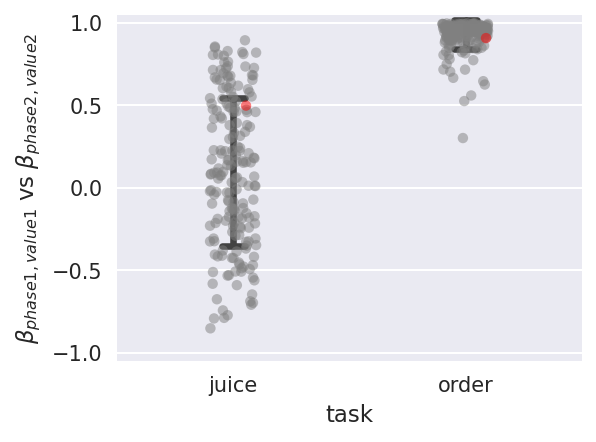

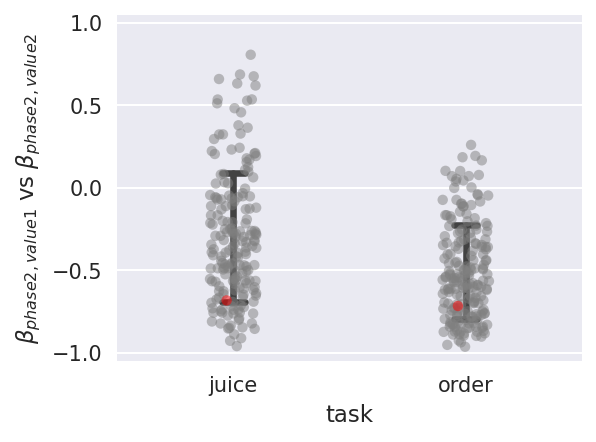

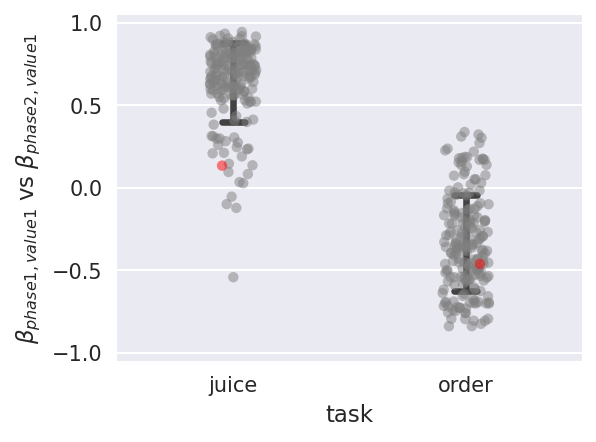

In [11]:
plt.style.use('seaborn-v0_8')
for y_var in ['c11_22','c21_22','c11_21']:
    fig,ax = plt.subplots(dpi=150,figsize=(4,3))
    sns.barplot(data=CorrDf,x='task',y=y_var, capsize=.1, errorbar="sd",ax=ax,fill=False,order=['juice','order'],alpha=0)
    sns.stripplot(data=CorrDf,x='task',y=y_var, alpha=.5, hue='example', legend=False,ax=ax,palette={False:'grey',True:'red'},order=['juice','order'])
    ax.set_ylabel(displayName[y_var])
    ax.set_ylim(-1.05,1.05)
    fig.savefig('./Figure/CorrRegCoef/offerEpochLast200Cross/'+y_var+'.pdf')

In [12]:
columns = 'b11,b12,b21,b22,b11p,b12p,b21p,b22p'.split(',')
displayName={
                         'b11' :r'$\beta_{phase1,value1}$',
                         'b12' :r'$\beta_{phase1,value2}$',
                         'b21' :r'$\beta_{phase2,value1}$',
                         'b22' :r'$\beta_{phase2,value2}$',
                         'b11p':r'$\beta_{phase1,value1}$',
                         'b12p':r'$\beta_{phase1,value2}$',
                         'b21p':r'$\beta_{phase2,value1}$',
                         'b22p':r'$\beta_{phase2,value2}$',
}
(b11,b12,b21,b22),(b11AB,b12AB,b21AB,b22AB),(b11BA,b12BA,b21BA,b22BA),(b11p,b12p,b21p,b22p) = getRegCoeff(dirPathJuice)
RegCoeffJuice = pd.DataFrame(np.vstack((b11,b12,b21,b22,b11p,b12p,b21p,b22p)).T,columns=columns)
RegCoeffJuice['task'] = 'juice'
(b11,b12,b21,b22),(b11AB,b12AB,b21AB,b22AB),(b11BA,b12BA,b21BA,b22BA),(b11p,b12p,b21p,b22p) = getRegCoeff(dirPathOrder)
RegCoeffOrder = pd.DataFrame(np.vstack((b11,b12,b21,b22,b11p,b12p,b21p,b22p)).T,columns=columns)
RegCoeffOrder['task'] = 'order'
RegDf = pd.concat((RegCoeffJuice,RegCoeffOrder))
RegDf

,b11,b12,b21,b22,b11p,b12p,b21p,b22p,task
0,-0.083187,0.033344,0.129325,-0.084534,-0.061547,0.005547,0.144502,-0.118351,juice
1,-0.091418,-0.016671,-0.176016,-0.009112,-0.103642,-0.003905,-0.195236,0.021161,juice
2,0.144863,-0.030182,-0.033650,0.100007,0.123751,0.000002,-0.006958,0.080841,juice
3,0.132227,-0.014946,-0.063708,0.090550,0.117008,0.006999,-0.030747,0.057617,juice
4,0.035853,-0.036586,-0.188284,0.055382,0.005179,0.000854,-0.209579,0.103508,juice
...,...,...,...,...,...,...,...,...,...
45,0.184422,0.009853,-0.258565,0.182136,0.185494,0.006890,-0.263259,0.181128,order
46,-0.220224,0.000970,0.262707,-0.186020,-0.219099,-0.001208,0.260323,-0.183577,order
47,-0.006790,0.003738,-0.096840,-0.001733,-0.008928,0.007742,-0.092129,-0.003489,order
48,-0.048768,0.021280,0.225796,-0.093917,-0.043389,0.009386,0.211754,-0.088095,order


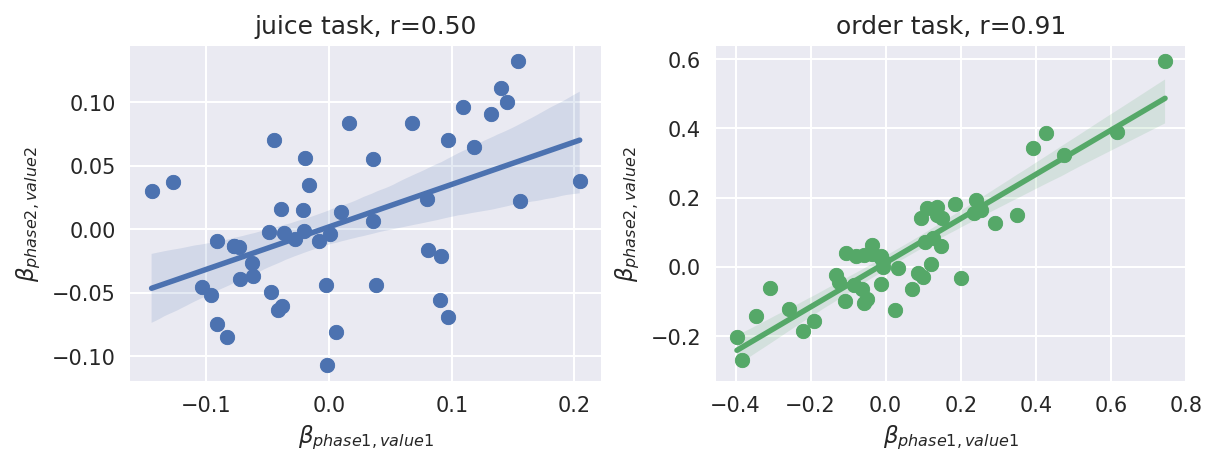

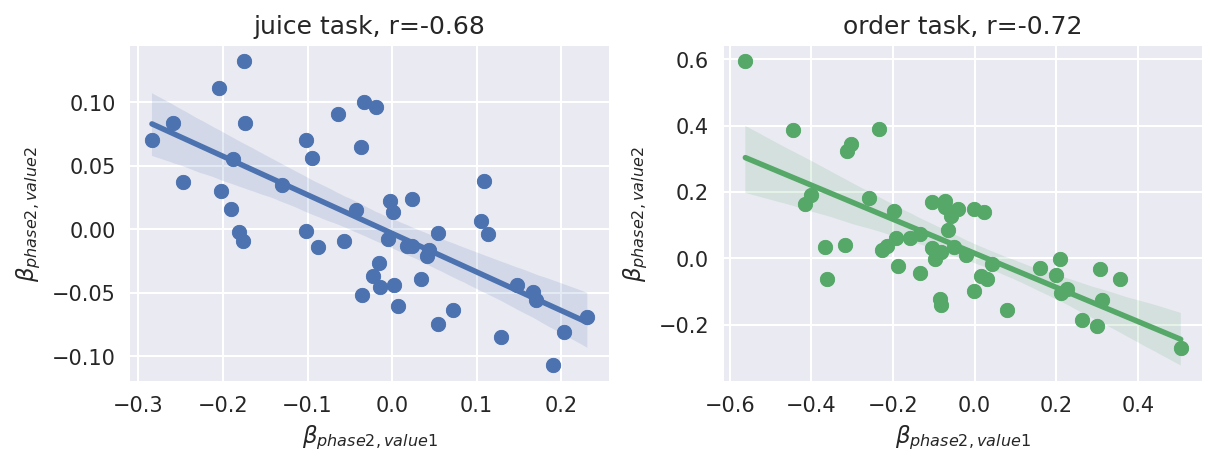

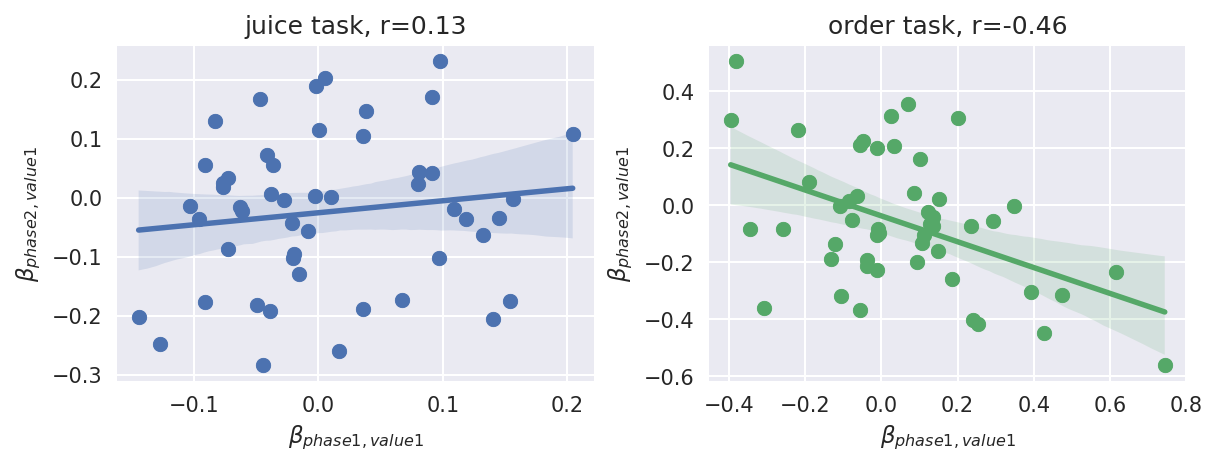

In [ ]:
from scipy.stats import pearsonr
for x_var,y_var in zip(
  ('b11','b21','b11'),
  ('b22','b22','b21')  
): 
    fig,(ax0,ax1) = plt.subplots(dpi=150,figsize=(8,3),ncols=2,constrained_layout=True)
    colors = (plt.rcParams['axes.prop_cycle'].by_key()['color'])
    ax=sns.regplot(data=RegDf[RegDf['task']=='juice'],x=x_var,y=y_var,color=colors[0],ax=ax0)
    ax.scatter(RegDf.loc[RegDf['task']=='juice',x_var],RegDf.loc[RegDf['task']=='juice',y_var],color=colors[0])
    ax.set_xlabel(displayName[x_var])
    ax.set_ylabel(displayName[y_var])
    corrcoef,P = pearsonr(RegDf.loc[RegDf['task']=='juice',[x_var,y_var]].T)
    ax.set_title(f'juice task, r={corrcoef:.2f}, P={P:.2e}')
    # ax.set_aspect('equal')

    ax=sns.regplot(data=RegDf[RegDf['task']=='order'],x=x_var,y=y_var,color=colors[1],ax=ax1)
    ax.scatter(RegDf.loc[RegDf['task']=='order',x_var],RegDf.loc[RegDf['task']=='order',y_var],color=colors[1])
    ax.set_xlabel(displayName[x_var])
    ax.set_ylabel(displayName[y_var])
    corrcoef,P =pearsonr(RegDf.loc[RegDf['task']=='order',[x_var,y_var]].T)
    ax.set_title(f'order task, r={corrcoef:.2f}, P={P:.2e}')
    # ax.set_aspect('equal')

    fig.savefig('./Figure/CorrRegCoef/offerEpochLast200Cross/'+x_var+'_'+y_var+'_split.pdf')